## Analysis of the unmodified data

#### Imports

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F, types as T

### Spark Setup

In [4]:
master = "local[2]"  # use 4 cores
app_name = "analyse Alibaba 2018 cluster trace"
config = SparkConf().setAll([
    ('spark.driver.memory', '3g'),
])

seed = 77

context = SparkContext(
    master=master,
    appName=app_name,
    conf=config
)
context.setCheckpointDir("spark_checkpoints")

spark_session = SparkSession.builder\
    .master(master)\
    .appName(app_name)\
    .config(conf=config)\
    .getOrCreate()

22/03/23 10:27:43 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.Con

### Job Status Distribution

In [5]:
batch_task_schema = T.StructType([
    # task name indicates the DAG information, see the explanation of batch workloads
    T.StructField("task_name", T.StringType(), nullable=False),  # task name. unique within a job
    # NOTE: tas_name doesn't change throughout different job executions
    T.StructField("instance_num", T.IntegerType(), nullable=True),  # number of instances for the task
    T.StructField("job_name", T.StringType(), nullable=True),
    T.StructField("task_type", T.IntegerType(), nullable=True),  # values 1-12, meaning unknown
    # Task states includes Ready | Waiting | Running | Terminated | Failed | Cancelled
    T.StructField("status", T.StringType(), nullable=True), # task status
    T.StructField("start_time", T.LongType(), nullable=True),  # start time of the task (in seconds since the start of the trace (0))
    T.StructField("end_time", T.LongType(), nullable=True),  # end of time the task (in seconds since the start of the trace (0))
    T.StructField("plan_cpu", T.DoubleType(), nullable=True),  # number of cpu needed by the task, 100 is 1 core
    T.StructField("plan_mem", T.DoubleType(), nullable=False) # normalized memory size, [0, 100]
])

batch_task_path = "../../data/alibaba_clusterdata_v2018/batch_task.tar.gz"
batch_task = spark_session.read.csv(path=batch_task_path,schema=batch_task_schema)

In [6]:
#batch_task.groupby("status").count().show()

In [7]:
#batch_task.count()

In [8]:
#batch_task.select("job_name").distinct().count()

In [9]:
#batch_task.select("job_name", "status").distinct().groupby("status").count().show()

In [10]:
# termination rate
termination_rate = 4127068 / 4201015

In [11]:
# failure rate
failure_rate = 83207 / 4201015

In [12]:
# runnning and waiting
run_wait_rate = (12537 + 49902) / 4201015

In [13]:
termination_rate, failure_rate, run_wait_rate

(0.9823978252874603, 0.019806403928574405, 0.014862836719221426)

In [14]:
sum([termination_rate, failure_rate, run_wait_rate])

1.017067065935256

In [15]:
# latex table number
98.23+1.98+1.48

101.69000000000001

### Job Failure Analysis

### batch_fail
- was cleaned on the cluster on 09.02.2022 using failed_instances.py

In [16]:
batch_fail_path = "../../out/clean/batch_fail/*.csv.gz"
batch_fail = spark_session.read.csv(path=batch_fail_path,header=True, inferSchema=True)

In [17]:
#batch_fail.count()

In [18]:
batch_fail.dtypes

[('task_name', 'string'),
 ('job_name', 'string'),
 ('instance_name', 'string'),
 ('task_type_inst', 'int'),
 ('status_inst', 'string'),
 ('start_time_inst', 'int'),
 ('end_time_inst', 'int'),
 ('machine_id_inst', 'string'),
 ('seq_no_inst', 'int'),
 ('total_seq_no_inst', 'int'),
 ('cpu_avg_inst', 'double'),
 ('cpu_max_inst', 'double'),
 ('mem_avg_inst', 'double'),
 ('mem_max_inst', 'double'),
 ('instance_num', 'int'),
 ('task_type', 'int'),
 ('status', 'string'),
 ('start_time', 'int'),
 ('end_time', 'int'),
 ('plan_cpu', 'double'),
 ('plan_mem', 'double')]

In [19]:
len(batch_fail.dtypes)

21

### Matplotlib setup

In [20]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn")

### Data cleaning
- scale resource columns and impute missing values

In [21]:
from pyspark.ml.feature import MinMaxScaler, Imputer, VectorAssembler
from pyspark.ml import Pipeline

res_cols = ["plan_cpu","cpu_avg_inst", "cpu_max_inst", "plan_mem", "mem_avg_inst", "mem_max_inst"]

# Imputer Transformatuon
imputer = Imputer(inputCols=res_cols, outputCols=[i+"_Imp" for i in res_cols])

# VectorAssembler Transformation - Converting column to vector type
assembler = VectorAssembler(inputCols=imputer.getOutputCols(),outputCol="res_cols_vect", handleInvalid="keep")

# MinMaxScaler Transformation
scaler = MinMaxScaler(inputCol="res_cols_vect", outputCol="res_cols_vect_scaled")


pipeline = Pipeline(stages=[imputer, assembler, scaler])

# Fitting pipeline on dataframe
batch_fail = pipeline.fit(batch_fail).transform(batch_fail)

In [22]:
# dropping intermediate cols to reduce the dataset size
for col in res_cols:
    batch_fail = batch_fail.drop(col)
for imp_col in imputer.getOutputCols():
    batch_fail = batch_fail.drop(imp_col)
batch_fail = batch_fail.drop(assembler.getOutputCol())

In [23]:
# unwrap vector column to tabular format
def split_array_to_list(col):
    def to_list(v):
        return v.toArray().tolist()
    return F.udf(to_list, T.ArrayType(T.DoubleType()))(col)

batch_fail = batch_fail.withColumn(
    "res_cols", 
    split_array_to_list(F.col("res_cols_vect_scaled"))
).select(
    F.col("task_type"),
    F.col("job_name"),
    F.col("task_name"),
    F.col("seq_no_inst"),
    F.col("task_type_inst"),
    F.col("instance_name"),
    F.col("total_seq_no_inst"),
    F.col("instance_num"),
    *[F.round(F.col("res_cols")[i], 5).alias(j) for i, j in zip(range(len(res_cols)),res_cols)]
)

In [24]:
# this barely fits in memory
pdf = batch_fail.toPandas()

In [25]:
#spark_session.stop()

In [26]:
pdf.dtypes

task_type              int32
job_name              object
task_name             object
seq_no_inst            int32
task_type_inst         int32
instance_name         object
total_seq_no_inst      int32
instance_num           int32
plan_cpu             float64
cpu_avg_inst         float64
cpu_max_inst         float64
plan_mem             float64
mem_avg_inst         float64
mem_max_inst         float64
dtype: object

In [27]:
pdf

,task_type,job_name,task_name,seq_no_inst,task_type_inst,instance_name,total_seq_no_inst,instance_num,plan_cpu,cpu_avg_inst,cpu_max_inst,plan_mem,mem_avg_inst,mem_max_inst
0,1,j_872298,J10_1_2_3_7_8_9,1,1,ins_383543020,1,503,0.00000,0.18135,0.14809,0.04821,0.03784,0.08902
1,1,j_1850126,J12_2_3_5_6_8_11,1,1,ins_541816524,1,1,0.00000,0.40000,0.10893,0.01846,0.00214,0.00000
2,1,j_948529,J13_9_12,1,1,ins_325791151,1,5,0.05263,0.18135,0.14809,0.05846,0.03784,0.08902
3,1,j_2652164,J15_3_14,1,1,ins_1247714824,1,355,0.05263,0.18135,0.14809,0.04821,0.03784,0.08902
4,1,j_3181289,J16_6_7_8_15,1,1,ins_354229891,1,363,0.05263,0.18135,0.14809,0.04821,0.03784,0.08902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665252,3,j_3840992,task_ODg3NTU4NTE3NDcxODA4NjA5Ng==,1,3,ins_1173173697,1,57,0.05263,0.18135,0.14809,0.00308,0.03784,0.08902
1665253,3,j_3840992,task_ODg3NTU4NTE3NDcxODA4NjA5Ng==,1,3,ins_929126161,1,57,0.05263,0.18135,0.14809,0.00308,0.03784,0.08902
1665254,3,j_3840992,task_ODg3NTU4NTE3NDcxODA4NjA5Ng==,1,3,ins_929126244,1,57,0.05263,0.18135,0.14809,0.00308,0.03784,0.08902
1665255,3,j_3840992,task_ODg3NTU4NTE3NDcxODA4NjA5Ng==,1,3,ins_569905413,1,57,0.05263,0.18135,0.14809,0.00308,0.03784,0.08902


### Descriptive statistics (violin plots)

In [33]:
# seaborn colors
import seaborn as sns
sns_cls = ["#34495e", "#3498db", "#e74c3c","#95a5a6",  "#9b59b6", "#2ecc71"]
# once for each variable
quantiles = np.arange(0.25, 1, 0.25)
quantiles_comp = [quantiles, quantiles, quantiles, quantiles, quantiles, quantiles]
quantiles

array([0.25, 0.5 , 0.75])

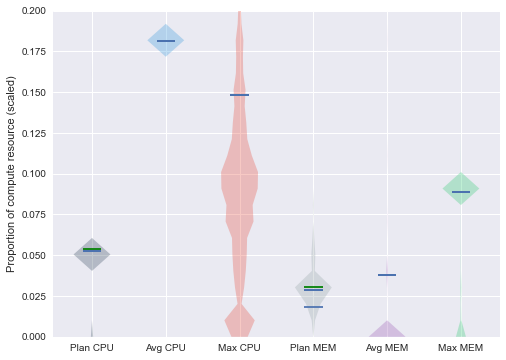

In [37]:
import itertools
fig = plt.figure(figsize=(8,6))
labels=["Plan CPU", "Avg CPU", "Max CPU", "Plan MEM", "Avg MEM", "Max MEM"]

violin = plt.violinplot(
    pdf[res_cols],
    #autorange=True,
    #whis = (0.00000, 0.50000),
    #,
    #meanline=True,
    showextrema=False,
    showmeans=True,
    #showmedians=True,
    quantiles=quantiles_comp
    #points=5
)
# limit values on the y-axis
ax = plt.gca()
ax.set_ylim([0.0, 0.20])
plt.xticks(ticks=[1,2,3,4,5,6], labels=labels)
plt.ylabel("Proportion of compute resource (scaled)")
# set mean to blue
#violin['cmeans'].set_color('b')
# set median to green
violin['cmeans'].set_color('g')
#violin['cmins'].set_color('r')
#violin['cmaxs'].set_color('r')
# set quantiles to yellow
#violin['cquantiles'].set_color('b')
# set the color of each violin
for b,c in zip(violin['bodies'],itertools.islice(itertools.cycle(sns_cls), 0, len(violin['bodies']))):
    b.set_facecolor(c)
#plt.title("Boxplots of the compute resource request and usage of failed instances")
plt.savefig("../../out/analysis/ali2018/violin_compute_res.pdf", format="pdf")

In [38]:
quantiles_tt_seq = [quantiles, quantiles, quantiles]

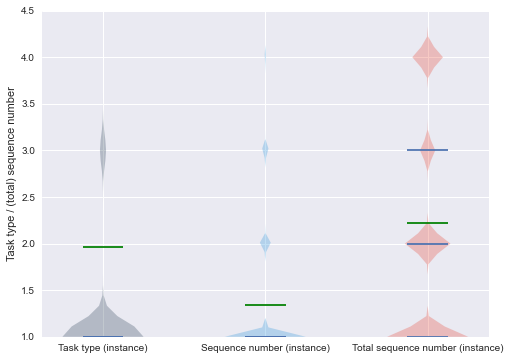

In [39]:
plt.figure(figsize=(8,6))
violin = plt.violinplot(
    pdf[["task_type", "seq_no_inst", "total_seq_no_inst"]],
    #meanline=True,
    showmeans=True,
    showextrema=False,
    #showmedians=True,
    quantiles=quantiles_tt_seq

)
labels=["Task type (instance)", "Sequence number (instance)", "Total sequence number (instance)"]

plt.xticks(ticks=[1,2,3], labels=labels)

# limit values on the y-axis
ax = plt.gca()
ax.set_ylim([1, 4.5])

# set mean to blue
#violin['cmeans'].set_color('b')
# set median to green
violin['cmeans'].set_color('g')
# set quantiles to yellow
#violin['cquantiles'].set_color('b')
# set the color of each violin
for b,c in zip(violin['bodies'],itertools.islice(itertools.cycle(sns_cls), 0, len(violin['bodies']))):
    b.set_facecolor(c)

plt.ylabel("Task type / (total) sequence number")
#plt.title("Boxplots of the task type and sequence of failed instances")
plt.savefig("../../out/analysis/ali2018/violin_tt_seq_inst.pdf", format="pdf")

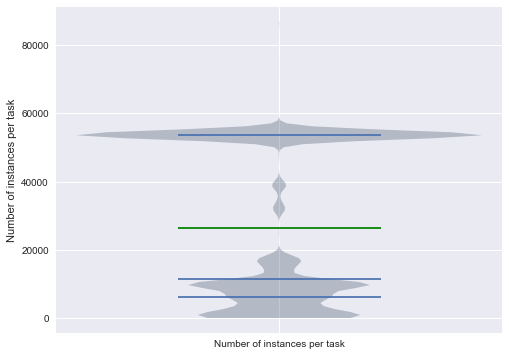

In [40]:
plt.figure(figsize=(8,6))

violin = plt.violinplot(
    pdf["instance_num"],
    #meanline=True,
    showmeans=True,
    showextrema=False,
    #showmedians=True,
    quantiles=quantiles
    
)
labels=["Number of instances per task"]
plt.xticks(ticks=[1], labels=labels)
plt.ylabel("Number of instances per task")

# set mean to blue
#violin['cmeans'].set_color('b')
# set median to green
violin['cmeans'].set_color('g')
# set quantiles to yellow
#violin['cquantiles'].set_color('b')
# set the color of each violin
for b,c in zip(violin['bodies'],itertools.islice(itertools.cycle(sns_cls), 0, len(violin['bodies']))):
    b.set_facecolor(c)
    
#plt.legend()
#plt.title("Boxplots of the compute resource request and usage of failed instances")
plt.savefig("../../out/analysis/ali2018/violin_instance_num.pdf", format="pdf")

## Analytical statistics

### Number of failed instances
- a) per Job ID
- continuous data

In [31]:
num_fail_inst_job_id = pdf.groupby(["job_name"]).size()

In [32]:
# set a range index
step = 1
num_fail_inst_job_id.index = pd.RangeIndex(start=0, stop=len(num_fail_inst_job_id.index) * step, step=step)

In [33]:
num_fail_inst_job_id.index

RangeIndex(start=0, stop=81329, step=1)

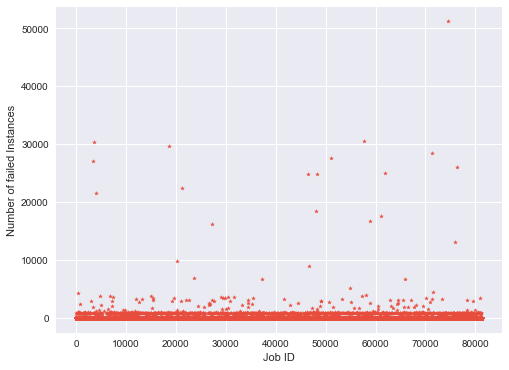

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(num_fail_inst_job_id.index, num_fail_inst_job_id, s=15, marker="*",color=sns_cls[2])
#plt.title("Number of failed instances per Job ID")
plt.xlabel("Job ID")
plt.ylabel("Number of failed Instances")
plt.savefig("../../out/analysis/ali2018/num_fail_inst_job_id.pdf", format="pdf")

In [35]:
num_fail_inst_job_id

0        1
1        1
2        1
3        1
4        1
        ..
81324    1
81325    1
81326    1
81327    1
81328    1
Length: 81329, dtype: int64

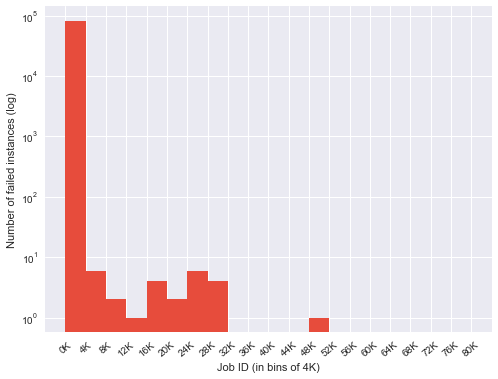

In [36]:
# 20 bins per histogram
num_fail_inst_job_id_hist = pdf.groupby(["job_name"]).size().to_frame()
num_fail_inst_job_id_hist = num_fail_inst_job_id_hist.rename(columns = {0:'count'})
num_fail_inst_job_id_hist.reset_index(inplace=True)
plt.figure(figsize=(8,6))
bins = range(0, 80001, 4000)
plt.hist(num_fail_inst_job_id_hist["count"], bins=bins, log=True, color=sns_cls[2])
plt.xticks(bins, labels=[str(i) +"K" for i in range(0,81,4)], rotation=40)
#plt.title("Number of failed instances per bin of Job IDs")
plt.xlabel("Job ID (in bins of 4K)")
plt.ylabel("Number of failed instances (log)")
plt.savefig("../../out/analysis/ali2018/hist_num_fail_inst_job_id.pdf", format="pdf")
plt.savefig("../../out/analysis/ali2018/hist_num_fail_inst_job_id.png", format="png")

In [37]:
num_fail_inst_job_id_hist["count"].min()

1

b) per Task ID

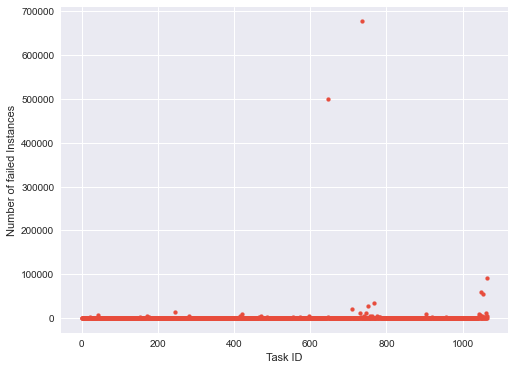

In [38]:
num_fail_inst_job_id = pdf.groupby(["task_name"]).size()
# set a range index
step = 1
num_fail_inst_job_id.index = pd.RangeIndex(start=0, stop=len(num_fail_inst_job_id.index) * step, step=step)
plt.figure(figsize=(8,6))
plt.scatter(num_fail_inst_job_id.index, num_fail_inst_job_id, s=15, marker="o", color=sns_cls[2])
#("Number of failed instances per Task ID")
plt.xlabel("Task ID")
plt.ylabel("Number of failed Instances")
plt.savefig("../../out/analysis/ali2018/num_fail_inst_task_id.pdf", format="pdf")
plt.savefig("../../out/analysis/ali2018/num_fail_inst_task_id.png", format="png")

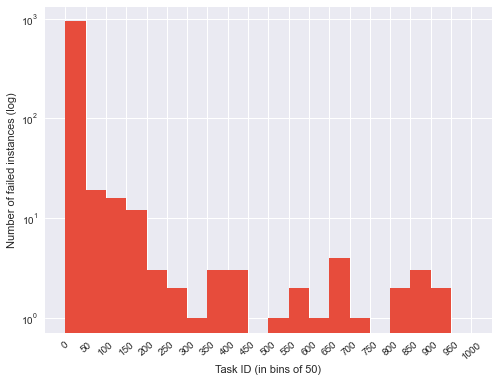

In [39]:
num_fail_inst_task_id_hist = pdf.groupby(["task_name"]).size().to_frame()
num_fail_inst_task_id_hist = num_fail_inst_task_id_hist.rename(columns = {0:'count'})
num_fail_inst_task_id_hist.reset_index(inplace=True)
plt.figure(figsize=(8,6))
bins = range(0, 1001, 50)
plt.hist(num_fail_inst_task_id_hist["count"], bins=bins, log=True, color=sns_cls[2])
plt.xticks(bins, labels=bins, rotation=40)
#plt.title("Number of failed instances per bin of Task IDs")
plt.xlabel("Task ID (in bins of 50)")
plt.ylabel("Number of failed instances (log)")
plt.savefig("../../out/analysis/ali2018/hist_num_fail_inst_task_id.pdf", format="pdf")
plt.savefig("../../out/analysis/ali2018/hist_num_fail_inst_task_id.png", format="png")

c) per Instance ID

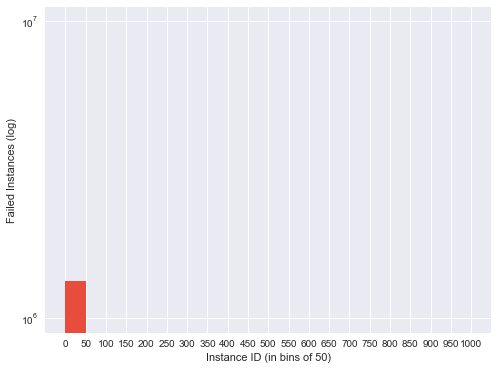

In [40]:
num_fail_inst_inst_id_hist = pdf.groupby(["instance_name"]).size().to_frame()
num_fail_inst_inst_id_hist = num_fail_inst_inst_id_hist.rename(columns = {0:'count'})
num_fail_inst_inst_id_hist.reset_index(inplace=True)
plt.figure(figsize=(8,6))
bins = range(0, 1001, 50)
plt.hist(num_fail_inst_inst_id_hist["count"], bins=bins, log=True, color=sns_cls[2])
plt.xticks(bins, labels=bins)
#plt.title("Number of failed instances per bin of Instance IDs")
plt.xlabel("Instance ID (in bins of 50)")
plt.ylabel("Failed Instances (log)")
plt.savefig("../../out/analysis/ali2018/hist_num_fail_inst_inst_id.pdf", format="pdf")

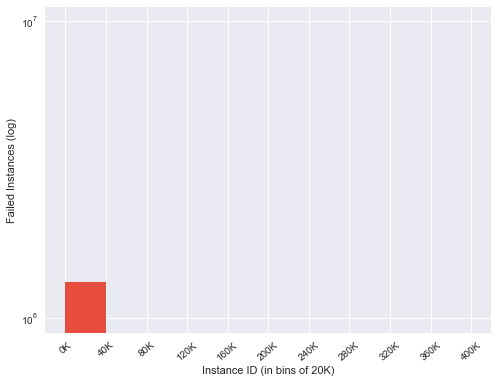

In [41]:
num_fail_inst_inst_id_hist = pdf.groupby(["instance_name"]).size().to_frame()
num_fail_inst_inst_id_hist = num_fail_inst_inst_id_hist.rename(columns = {0:'count'})
num_fail_inst_inst_id_hist.reset_index(inplace=True)
plt.figure(figsize=(8,6))
bins = range(0, 400001, 40000)
plt.hist(num_fail_inst_inst_id_hist["count"], bins=bins, log=True, color=sns_cls[2])
plt.xticks(bins, labels=[str(i) +"K" for i in range(0,401,40)], rotation=40)
#plt.title("Number of failed instances per bin of Instance IDs")
plt.xlabel("Instance ID (in bins of 20K)")
plt.ylabel("Failed Instances (log)")
plt.savefig("../../out/analysis/ali2018/hist_num_fail_inst_inst_id.pdf", format="pdf")

d) per Machine ID

In [42]:
num_fail_inst_job_id = pdf.groupby(["machine_id_inst"]).size()
# set a range index
step = 1
num_fail_inst_job_id.index = pd.RangeIndex(start=0, stop=len(num_fail_inst_job_id.index) * step, step=step)
plt.figure(figsize=(8,6))
plt.scatter(num_fail_inst_job_id.index, num_fail_inst_job_id, s=15, marker="s", color=sns_cls[2])
#plt.title("Number of failed instances per Machine ID")
plt.xlabel("Machine ID")
plt.ylabel("Number of failed Instances")
plt.savefig("../../out/analysis/ali2018/num_fail_inst_machine_id.pdf", format="pdf")

KeyError: 'machine_id_inst'

In [ ]:
num_fail_machine_machine_id_hist = pdf.groupby(["machine_id_inst"]).size().to_frame()
num_fail_machine_machine_id_hist = num_fail_machine_machine_id_hist.rename(columns = {0:'count'})
num_fail_machine_machine_id_hist.reset_index(inplace=True)
plt.figure(figsize=(8,6))
bins = range(0, 4001, 200)
plt.hist(num_fail_machine_machine_id_hist["count"], bins=bins, log=True, color=sns_cls[2])
plt.xticks(bins, labels=bins, rotation=40)
#plt.title("Number of failed instances per bin of machine IDs")
plt.xlabel("Machine ID (in bins of 200)")
plt.ylabel("Failed instances (log)")
plt.savefig("../../out/analysis/ali2018/hist_num_fail_machine_machine_id.pdf", format="pdf")

## Relations in Scatterplots

In [ ]:
np.unique(pdf["task_type_inst"])

In [ ]:
cpu_request_inst_fail = pdf.groupby(["plan_cpu", "task_type_inst"]).size().to_frame()
cpu_request_inst_fail = cpu_request_inst_fail.rename(columns = {0:'count'})
# apply normalization (0-100) on the count for a smaller size
cpu_request_inst_fail["count_normalized"] = cpu_request_inst_fail["count"] /cpu_request_inst_fail["count"].abs().max()
#cpu_request_inst_fail["count_normalized"] = cpu_request_inst_fail["count_normalized"] * 100
cpu_request_inst_fail.reset_index(inplace=True)

In [ ]:
cpu_request_inst_fail

b) requested MEM

In [ ]:
mem_request_inst_fail = pdf.groupby(["plan_mem", "task_type_inst"]).size().to_frame()
mem_request_inst_fail = mem_request_inst_fail.rename(columns = {0:'count'})
# apply normalization from (0-100) on the count for a smaller size
mem_request_inst_fail["count_normalized"] = mem_request_inst_fail["count"] /mem_request_inst_fail["count"].abs().max()
#mem_request_inst_fail["count_normalized"] = mem_request_inst_fail["count_normalized"] * 100
mem_request_inst_fail.reset_index(inplace=True)

In [ ]:
mem_request_inst_fail

In [ ]:
avg_mem_inst_fail = pdf.groupby(["mem_avg_inst", "task_type_inst"]).size().to_frame()
avg_mem_inst_fail = avg_mem_inst_fail.rename(columns = {0:'count'})
avg_mem_inst_fail.reset_index(inplace=True)

avg_cpu_inst_fail = pdf.groupby(["cpu_avg_inst", "task_type_inst"]).size().to_frame()
avg_cpu_inst_fail = avg_cpu_inst_fail.rename(columns = {0:'count'})
avg_cpu_inst_fail.reset_index(inplace=True)

In [ ]:
cpu_request_inst_fail.set_index("task_type_inst", inplace=True)

In [ ]:
cpu_request_inst_fail

In [ ]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
cdict = {1: sns_cls[0], 3: sns_cls[1], 8: sns_cls[2], 10: sns_cls[3], 11: sns_cls[4], 12: sns_cls[5]}

sns.barplot(x="plan_cpu", y="count_normalized", data=cpu_request_inst_fail[cpu_request_inst_fail.index==1],color=sns_cls[0])
sns.barplot(x="plan_cpu", y="count_normalized", data=cpu_request_inst_fail[cpu_request_inst_fail.index==3],color=sns_cls[1])
sns.barplot(x="plan_cpu", y="count_normalized", data=cpu_request_inst_fail[cpu_request_inst_fail.index==8],color=sns_cls[2])
sns.barplot(x="plan_cpu", y="count_normalized", data=cpu_request_inst_fail[cpu_request_inst_fail.index==10],color=sns_cls[3])
sns.barplot(x="plan_cpu", y="count_normalized", data=cpu_request_inst_fail[cpu_request_inst_fail.index==11],color=sns_cls[4])
sns.barplot(x="plan_cpu", y="count_normalized", data=cpu_request_inst_fail[cpu_request_inst_fail.index==12],color=sns_cls[5])
#cpu_request_inst_fail.plot(kind="bar", stacked=True, color=sns_cls)

plt.xlabel("Requested CPU cores (normalized)")
plt.ylabel("Number of failed instances")
ax.legend()


Text(0, 0.5, 'Count (log)')

<Figure size 576x432 with 0 Axes>

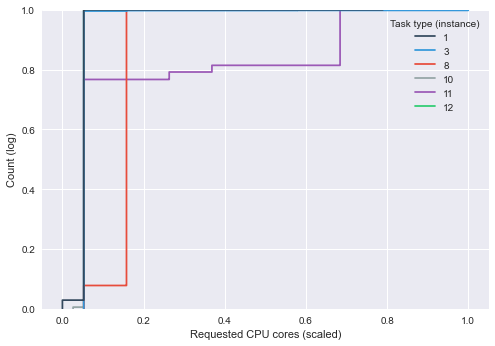

In [50]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
cdict = {1: sns_cls[0], 3: sns_cls[1], 8: sns_cls[2], 10: sns_cls[3], 11: sns_cls[4], 12: sns_cls[5]}
pdf.rename(columns = {'task_type_inst':'Task type (instance)'}, inplace = True)
sns.ecdfplot(data=pdf, x="plan_cpu", hue="Task type (instance)", palette=sns_cls, legend=True) #stat="count", log_scale=(False,True))
#ax = plt.gca()
#ax.set_xlim([0.0, 0.80])
#ax.set_ylim([10**0, 10**6.5])
#plt.xticks(ticks=pdf["plan_cpu"], labels=np.arange(0,1,0.1))

plt.xlabel("Requested CPU cores (scaled)")
plt.ylabel("Count (log)")
#plt.savefig("../../out/analysis/ali2018/ecdf_cpu_request_tt_inst_fail.pdf", format="pdf")

<Figure size 576x432 with 0 Axes>

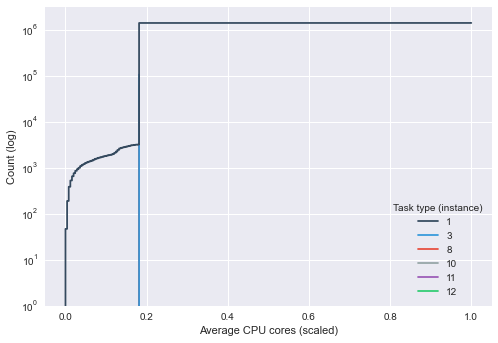

In [44]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
sns.ecdfplot(data=pdf, x="cpu_avg_inst", hue="Task type (instance)", palette=sns_cls, legend=True, stat="count", log_scale=(False, True))
#ax = plt.gca()
ax.set_ylim([10**0, 10**6.5])

plt.xlabel("Average CPU cores (scaled)")
plt.ylabel("Count (log)")
plt.savefig("../../out/analysis/ali2018/ecdf_cpu_avg_tt_inst_fail.pdf", format="pdf")

<Figure size 576x432 with 0 Axes>

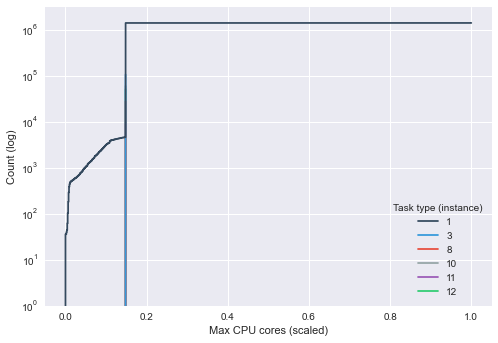

In [45]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
sns.ecdfplot(data=pdf, x="cpu_max_inst", hue="Task type (instance)", palette=sns_cls, legend=True, stat="count", log_scale=(False, True))
#ax = plt.gca()
ax.set_ylim([10**0, 10**6.5])

plt.xlabel("Max CPU cores (scaled)")
plt.ylabel("Count (log)")
plt.savefig("../../out/analysis/ali2018/ecdf_cpu_max_tt_inst_fail.pdf", format="pdf")

<Figure size 576x432 with 0 Axes>

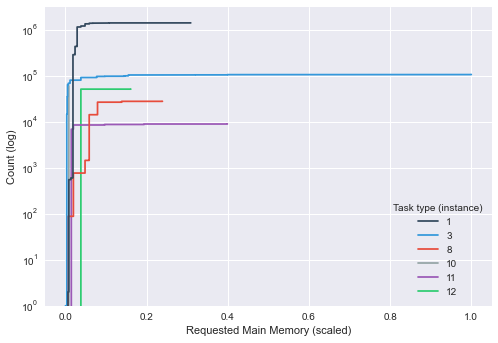

In [46]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
cdict = {1: sns_cls[0], 3: sns_cls[1], 8: sns_cls[2], 10: sns_cls[3], 11: sns_cls[4], 12: sns_cls[5]}

sns.ecdfplot(data=pdf, x="plan_mem", hue="Task type (instance)", palette=sns_cls, legend=True, stat="count", log_scale=(False, True))
ax.set_ylim([10**0, 10**6.5])
#plt.xticks(ticks=pdf["plan_mem"], labels=mem_range)
plt.xlabel("Requested Main Memory (scaled)")
plt.ylabel("Count (log)")
plt.savefig("../../out/analysis/ali2018/ecdf_mem_request_tt_inst_fail.pdf", format="pdf")

<Figure size 576x432 with 0 Axes>

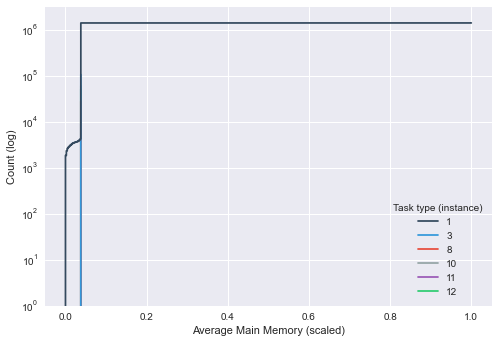

In [47]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
sns.ecdfplot(data=pdf, x="mem_avg_inst", hue="Task type (instance)", palette=sns_cls, legend=True, stat="count", log_scale=(False, True))
#ax = plt.gca()
#ax.set_xlim([0.0, 0.60])
ax.set_ylim([10**0, 10**6.5])

plt.xlabel("Average Main Memory (scaled)")
plt.ylabel("Count (log)")
plt.savefig("../../out/analysis/ali2018/ecdf_mem_avg_tt_inst_fail.pdf", format="pdf")

<Figure size 576x432 with 0 Axes>

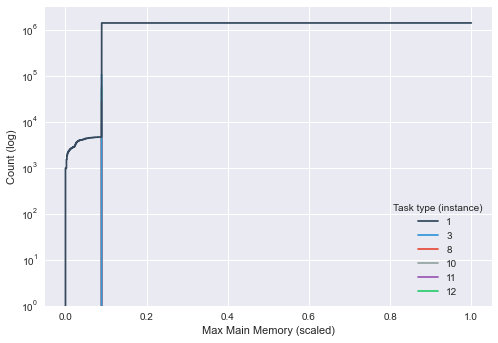

In [48]:
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
sns.ecdfplot(data=pdf, x="mem_max_inst", hue="Task type (instance)", palette=sns_cls, legend=True, stat="count", log_scale=(False, True))
#ax = plt.gca()
#ax.set_xlim([0.0, 0.60])
ax.set_ylim([10**0, 10**6.5])

plt.xlabel("Max Main Memory (scaled)")
plt.ylabel("Count (log)")
plt.savefig("../../out/analysis/ali2018/ecdf_mem_max_tt_inst_fail.pdf", format="pdf")

<Figure size 576x432 with 0 Axes>

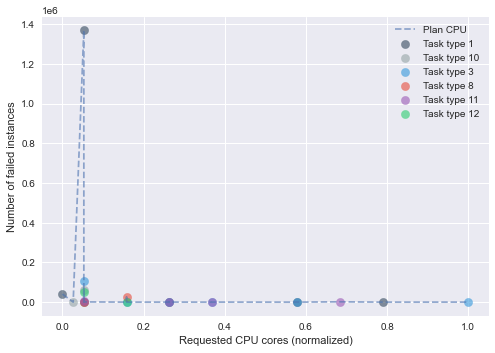

In [35]:
plt.figure(figsize=(8,6))

# one for each task type
cdict = {1: sns_cls[0], 3: sns_cls[1], 8: sns_cls[2], 10: sns_cls[3], 11: sns_cls[4], 12: sns_cls[5]}

fig, ax = plt.subplots()
ax.plot(
    cpu_request_inst_fail["plan_cpu"],
    cpu_request_inst_fail["count"],
    alpha=0.6,
    label="Plan CPU",
    linestyle="--"
)

for tt in cpu_request_inst_fail["task_type_inst"].unique():
    ix = np.where(cpu_request_inst_fail["task_type_inst"] == tt)
    avg_ix = np.where(avg_cpu_inst_fail["task_type_inst"] == tt)
    # scatter plot for cpu
    ax.scatter(
        cpu_request_inst_fail["plan_cpu"].iloc[ix],
        cpu_request_inst_fail["count"].iloc[ix],
        c = cdict[tt],
        marker="o",
        label = f"Task type {tt}",
        s = 70,
        alpha=0.6
    )
#plt.title("CPU core requests per task type of failed instances")
plt.xlabel("Requested CPU cores (normalized)")
plt.ylabel("Number of failed instances")
ax.legend()
#plt.savefig("../../out/analysis/ali2018/scatter_cpu_request_tt_inst_fail.pdf", format="pdf")
#plt.savefig("../../out/analysis/ali2018/scatter_cpu_request_tt_inst_fail.png", format="png")

In [ ]:
plt.figure(figsize=(8,6))

fig, ax = plt.subplots()

ax.plot(
    mem_request_inst_fail["plan_mem"],
    mem_request_inst_fail["count"],
    alpha=0.6,
    label="Plan MEM",
    linestyle="--",
    color="green"
)
for tt in cpu_request_inst_fail["task_type_inst"].unique():
    ix = np.where(cpu_request_inst_fail["task_type_inst"] == tt)
    # scatter plot for mem
    ax.scatter(
        mem_request_inst_fail["plan_mem"].iloc[ix],
        mem_request_inst_fail["count"].iloc[ix],
        c = cdict[tt],
        marker="o",
        label = f"Task type {tt}",
        s = 70,
        alpha=0.6
    )
#plt.title("Main Memory requests per task type of failed instances")
plt.xlabel("Requested Main Memory (normalized)")
plt.ylabel("Number of failed instances")
ax.legend()
plt.savefig("../../out/analysis/ali2018/scatter_mem_request_tt_inst_fail.pdf", format="pdf")
plt.savefig("../../out/analysis/ali2018/scatter_mem_request_tt_inst_fail.png", format="png")

c) average used resources

In [ ]:
plt.figure(figsize=(8,6))

# one for each task type
cdict = {1: sns_cls[0], 3: sns_cls[1], 8: sns_cls[2], 10: sns_cls[3], 11: sns_cls[4], 12: sns_cls[5]}

fig, ax = plt.subplots()
ax.plot(
    avg_cpu_inst_fail["cpu_avg_inst"],
    avg_cpu_inst_fail["count"],
    alpha=0.6,
    label="Avg CPU",
)

for tt in avg_cpu_inst_fail["task_type_inst"].unique():
    ix = np.where(avg_cpu_inst_fail["task_type_inst"] == tt)
    # scatter plot for cpu
    ax.scatter(
        avg_cpu_inst_fail["cpu_avg_inst"].iloc[ix], 
        avg_cpu_inst_fail["count"].iloc[ix],
        c = cdict[tt],
        marker="o",
        label = f"Task type {tt}",
        s = 70,
        alpha=0.6
    )
#plt.title("Average CPU core usage per task type of failed instances")
plt.xlabel("Average CPU cores (normalized)")
plt.ylabel("Number of failed instances")
ax.legend()
plt.savefig("../../out/analysis/ali2018/scatter_avg_cpu_tt_inst_fail.pdf", format="pdf")
plt.savefig("../../out/analysis/ali2018/scatter_avg_cpu_tt_inst_fail.png", format="png")

In [ ]:
plt.figure(figsize=(8,6))

fig, ax = plt.subplots()

ax.plot(
    avg_mem_inst_fail["mem_avg_inst"],
    avg_mem_inst_fail["count"],
    alpha=0.6,
    label="Avg MEM",
    color="green"
)
for tt in avg_mem_inst_fail["task_type_inst"].unique():
    ix = np.where(avg_mem_inst_fail["task_type_inst"] == tt)
    # scatter plot for mem
    ax.scatter(
        avg_mem_inst_fail["mem_avg_inst"].iloc[ix],
        avg_mem_inst_fail["count"].iloc[ix],
        c = cdict[tt],
        marker="o",
        label = f"Task type {tt}",
        s = 70,
        alpha=0.6
    )
#plt.title("Average Main Memory usage per task type of failed instances")
plt.xlabel("Average Main Memory (normalized)")
plt.ylabel("Number of failed instances")
ax.legend()
plt.savefig("../../out/analysis/ali2018/scatter_avg_mem_tt_inst_fail.pdf", format="pdf")
plt.savefig("../../out/analysis/ali2018/scatter_avg_mem_tt_inst_fail.png", format="png")